In [1]:
import torch
import json
import numpy as np
import pickle
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data
from applefy.utils.file_handling import save_as_fits, open_fits

## Load the data

In [16]:
print("Loading data ... ", end='')
science_data_new, _, _ = \
    load_adi_data("/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5",
                  data_tag="object",
                  psf_template_tag="psf_template",
                  para_tag="header_object/PARANG")

science_data_new = science_data_new[:, 17:-17, 17:-17]
print("[DONE]")

Loading data ... [DONE]


In [17]:
print("Loading data ... ", end='')
science_data_old, _, _ = \
    load_adi_data("/fast/mbonse/s4/30_data/old_datasets/HD22049_303_199_C-0065_C_.hdf5",
                  data_tag="13_object_final",
                  psf_template_tag="10_psf",
                  para_tag="header_13_object_final/PARANG")

print("[DONE]")

Loading data ... [DONE]


In [18]:
science_data_new.shape

(57961, 107, 107)

In [19]:
science_data_old.shape

(64334, 107, 107)

In [ ]:
save_as_fits(
    science_data_new[::10],
    "/fast/mbonse/s4/70_results/04_alignment/new_data.fits")

In [10]:
save_as_fits(
    science_data_old[::10],
    "/fast/mbonse/s4/70_results/04_alignment/old_data.fits")

# Test the alignment

In [20]:
reference = open_fits("/fast/mbonse/s4/30_data/Ref_PSF/ref_psf.fits")

In [21]:
reference[77:-77, 77:-77].shape

(107, 107)

In [22]:
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

In [23]:
mean_frame_new = np.mean(science_data_new, axis=0)
mean_frame_old = np.mean(science_data_old, axis=0)

In [24]:
shifts = []
shifted_frames = np.zeros_like(science_data_new)

for i in tqdm(range(science_data_new.shape[0])):
    tmp_shift = phase_cross_correlation(
        reference[77:-77, 77:-77],
        science_data_new[i, :, :],
        normalization=None,
        upsample_factor=10)[0]
    shifts.append(tmp_shift)
    
    shifted_frames[i, :, :] = shift(
        science_data_new[i, :, :], 
        tmp_shift, 
        order=5, 
        mode="constant")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57961/57961 [03:50<00:00, 250.96it/s]


In [25]:
distance_shift = np.sqrt(np.array(shifts)[:, 0]**2 + np.array(shifts)[:, 1]**2)

In [26]:
mse_distances = np.mean((science_data_new - mean_frame_new)**2, axis=(1, 2))

In [27]:
cutoff = int(len(mse_distances) / 100 * 5)
cutoff_5percent = np.sort(mse_distances)[-cutoff]

cutoff = int(len(mse_distances) / 100 * 10)
cutoff_10percent = np.sort(mse_distances)[-cutoff]

cutoff = int(len(mse_distances) / 100 * 20)
cutoff_20percent = np.sort(mse_distances)[-cutoff]

(0.0, 7.0)

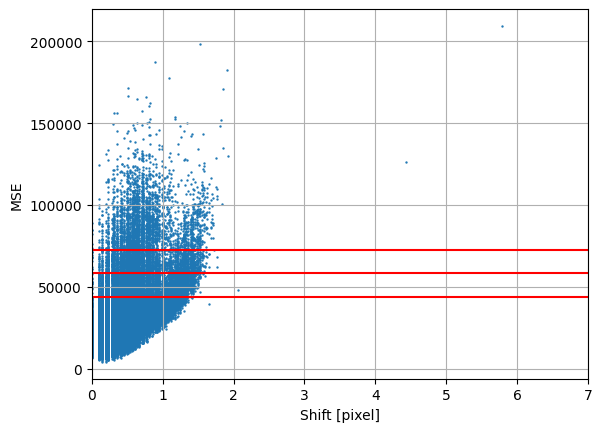

In [28]:
plt.hlines([cutoff_5percent, cutoff_10percent, cutoff_20percent], 
           xmin=0, xmax=8, color="red")
plt.scatter(distance_shift, mse_distances, s=0.5)
plt.xlabel("Shift [pixel]")
plt.ylabel("MSE")

plt.grid()
plt.xlim(0, 7)

# Frame selection based on shifts

In [21]:
mask = distance_shift > 0.8

In [22]:
np.sum(mask) / len(mask)

0.05783080903802099

In [17]:
bad_frames = science_data_new[distance_shift > 1.0]
good_frames = science_data_new[distance_shift < 1.0]
good_frames_shifted = shifted_frames[distance_shift < 1.0]

In [18]:
save_as_fits(
    bad_frames[::10], 
    "/fast/mbonse/s4/70_results/04_alignment/new_data_bad.fits")

save_as_fits(
    good_frames[::10], 
    "/fast/mbonse/s4/70_results/04_alignment/new_data_good.fits")

save_as_fits(
    good_frames_shifted[::10], 
    "/fast/mbonse/s4/70_results/04_alignment/new_data_good_shifted.fits")

In [19]:
bad_frames.shape

(1181, 107, 107)

In [20]:
good_frames.shape

(59387, 107, 107)